***Классификация пород кошек и собак по лицу***

Для начала загрузим упрощенный датасет - [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [13]:
#lib import
from keras import utils
from keras import layers
from keras.models import Sequential
from keras.metrics import SparseTopKCategoricalAccuracy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
from pathlib import Path

In [14]:
#dataset loading
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
data = Path(utils.get_file('petfaces', origin=url, untar=True))

In [15]:
# This section of the code is used to divide the dataset into a training set and a test set.

# The image size for both the training and test sets is defined as 256x256 pixels.
# The training set is created using the 'image_dataset_from_directory' function.
# This function takes the directory of the data as input, and uses a validation split of 0.2,
# meaning that 80% of the data will be used for training and 20% for validation.
# The 'subset' parameter is set to 'training', which means that this function call will return the training set.
# The 'seed' parameter is set to 3000 to ensure that the split is reproducible.
# The 'image_size' parameter is set to the previously defined 'img_size', and the 'batch_size' is set to 32.

img_size = 256, 256

train_set = utils.image_dataset_from_directory (
    data,
    validation_split=0.2,
    subset='training',
    seed=3000,
    image_size=img_size,
    batch_size=32)

# The test set is created in a similar way to the training set, but with the 'subset' parameter set to 'validation'
# This means that this function call will return the validation set, which will be used as the test set.
test_set = utils.image_dataset_from_directory (
    data,
    validation_split=0.2,
    subset='validation',
    seed=3000,
    image_size=img_size,
    batch_size=32)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Далее разделим полученный датасет на классы: кошки и собаки (cats/dogs)

In [16]:
# Extract class names from the training set
class_names = train_set.class_names

# Initialize empty lists to store indices of cat and dog classes
class_cats = []
class_dogs = []

# Loop through the class names
for _ in range(len(class_names)):
    # If the class name starts with 'cat', append its index to the cat list
    if class_names[_].startswith('cat'):
        class_cats.append(_)
    # If the class name starts with 'dog', append its index to the dog list
    if class_names[_].startswith('dog'):
        class_dogs.append(_)

# Cache and shuffle the training set for better performance
# Shuffle buffer size is half the size of the training set
train_set = train_set.cache().shuffle(3000 // 2).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache the test set for better performance
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Создадим модель, определив максимально подходящие гиперпараметры опытным путем. Архитектура получилась такой: первый слой - случайное отражение, случайный поворот, случайное увеличение, 6 раз применить свертку и пуллинг, слой Flatten, слой Dropout с вероятностью 0.2, слой Dense с функцией активации sigmoid.

In [17]:
# Initialize the Sequential model
model = Sequential()

# Add a layer that randomly flips the input images horizontally
model.add(layers.RandomFlip("horizontal"))

# Add a layer that randomly rotates the input images by a small angle
model.add(layers.RandomRotation(0.1))

# Add a layer that randomly zooms the input images by a small amount
model.add(layers.RandomZoom(0.1))

# Add a convolutional layer with 8 filters, each of size 3x3
# Use the ReLU activation function
# The input shape is 256x256 RGB images
model.add(layers.Conv2D(8, 3, activation='relu', input_shape=(256, 256, 3)))

# Add a max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D(2))

# Add a convolutional layer with 16 filters, each of size 3x3
# Use the ReLU activation function
model.add(layers.Conv2D(16,  3, activation='relu'))

# Add a max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D(2))

# Add a convolutional layer with 32 filters, each of size 3x3
# Use the ReLU activation function
model.add(layers.Conv2D(32, 3, activation='relu'))

# Add a max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D(2))

# Add a convolutional layer with 64 filters, each of size 3x3
# Use the ReLU activation function
model.add(layers.Conv2D(64, 3, activation='relu'))

# Add a max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D(2))

# Add a convolutional layer with 128 filters, each of size 3x3
# Use the ReLU activation function
model.add(layers.Conv2D(128, 3, activation='relu'))

# Add a max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D(2))

# Add a convolutional layer with 256 filters, each of size 3x3
# Use the ReLU activation function
model.add(layers.Conv2D(256, 3, activation='relu'))

# Add a max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D(2))

# Flatten the tensor output from the previous layer
model.add(layers.Flatten())

# Add a dropout layer with dropout rate 0.2 to prevent overfitting
model.add(layers.Dropout(0.2))

# Add a dense layer with output size equal to the number of classes
# Use the sigmoid activation function for multi-label classification
model.add(layers.Dense(len(class_names), activation = 'sigmoid'))

C:\Users\aleks\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Произведём обучение модели в течении 40 эпох, оптимизатор - Adam.

In [18]:
# Define the top-3 accuracy metric
# SparseTopKCategoricalAccuracy calculates the top-k categorical accuracy for sparse categorical targets
top3_accuracy = SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')

# Define the optimizer
# Adam optimizer is used with a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Record the start time
start_time = time.time()

# Compile the model
# The model is compiled with Adam optimizer, sparse categorical crossentropy loss, and accuracy and top-3 accuracy metrics
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', top3_accuracy])

# Define the number of epochs
epochs = 40

# Train the model
# The model is trained for 40 epochs on the training set and validated on the test set
history = model.fit(train_set, validation_data=test_set, epochs=epochs)

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.0476 - loss: 6.6962 - top3_accuracy: 0.1178 - val_accuracy: 0.0903 - val_loss: 3.3036 - val_top3_accuracy: 0.2165
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.0944 - loss: 3.2367 - top3_accuracy: 0.2378 - val_accuracy: 0.2103 - val_loss: 2.8341 - val_top3_accuracy: 0.4050
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.1898 - loss: 2.8580 - top3_accuracy: 0.3992 - val_accuracy: 0.2835 - val_loss: 2.5687 - val_top3_accuracy: 0.4875
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.2496 - loss: 2.6250 - top3_accuracy: 0.4830 - val_accuracy: 0.3474 - val_loss: 2.2267 - val_top3_accuracy: 0.6199
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.3115 - loss: 2.3705 - top3_accuracy: 0.5571 - val_accuracy: 0.4128 - val_loss: 2.0747 - val_top3_accuracy: 0.6417
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.3599 - loss: 2.1603 - top3_a

После обучения модели получим из "истории" все необходимые нам метрики по ключу.

In [19]:
# Extracting training and testing accuracy, loss, and top3 accuracy from the history object
train_accuracy = history.history['accuracy']  # Accuracy on the training data
test_accuracy = history.history['val_accuracy']  # Accuracy on the testing data
train_loss = history.history['loss']  # Loss on the training data
test_loss = history.history['val_loss']  # Loss on the testing data
train_top3_accuracy = history.history['top3_accuracy']  # Top3 accuracy on the training data
test_top3_accuracy = history.history['val_top3_accuracy']  # Top3 accuracy on the testing data

# Record the end time of the execution
end_time = time.time()

Рассчитаем точность бинарной классификации.

In [20]:
# Initialize correct and total predictions to 0
correct, total = 0, 0

# Loop through each example in the test set
for x, y in test_set:
    # Predict the class of the input using the model
    y_pred = np.argmax(model.predict(x), axis=1)

    # Count the number of correct predictions for cats
    correct_cats = sum(
        y_pred[i] in class_cats and y[i] in class_cats for i in range(len(y))
    )

    # Count the number of correct predictions for dogs
    correct_dogs = sum(
        y_pred[i] in class_dogs and y[i] in class_dogs for i in range(len(y))
    )

    # Add the number of correct predictions for cats and dogs to the total number of correct predictions
    correct += correct_cats + correct_dogs

    # Add the total number of predictions made to the total count
    total += len(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Рассчитаем confusion matrix.

In [21]:
# Initialize empty arrays to store real and predicted labels
y_real = np.array([])
y_pred = np.array([])

# Iterate over the test set
for x, y in test_set:
    # Concatenate the real labels to the y_real array
    y_real = np.concatenate((y_real, y), axis=None)
    # Concatenate the predicted labels (obtained from the model) to the y_pred array
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)

# Compute the confusion matrix using TensorFlow's math.confusion_matrix function
confusion_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=len(class_names))

# Convert the confusion matrix into a pandas DataFrame for better visualization
# The index and columns of the DataFrame are the class names
df_cm = pd.DataFrame(
    confusion_matrix, index=list(class_names), columns=list(class_names)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Построим и выведем матрицу.

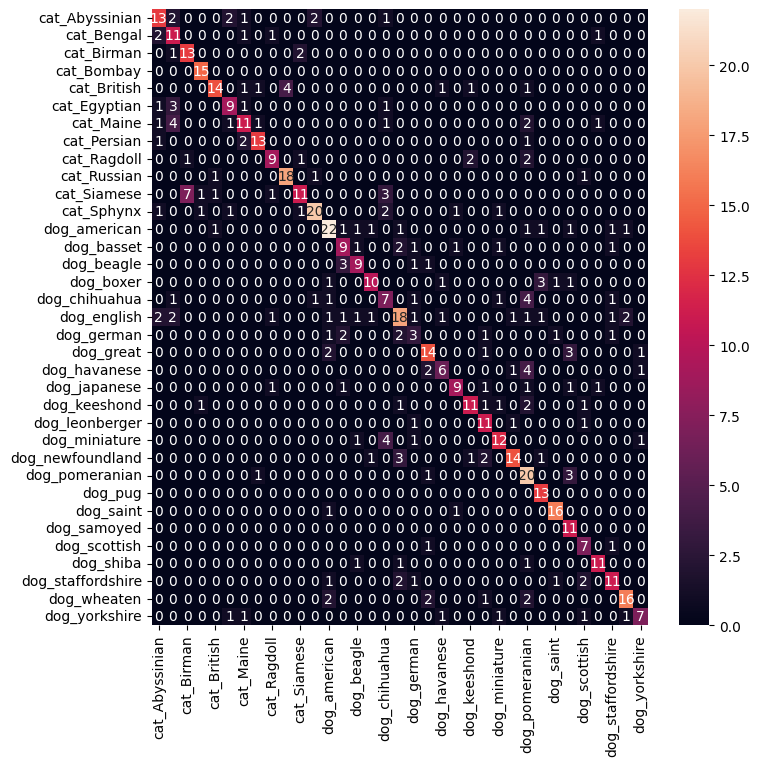

In [22]:
plt.figure(figsize = (8, 8))
sn.heatmap(df_cm, annot=True)
plt.show()

Выведем метрики и время полученные в результате всех наших действий.

In [23]:
print('\nFinal train accuracy:', train_accuracy[epochs - 1])
print('Final test accuracy:', test_accuracy[epochs - 1])
print('\nFinal train loss:', train_loss[epochs - 1])
print('Final test loss:', test_loss[epochs - 1])
print('\nBinary classification accuracy:', correct / total)
print('\nFinal train top-3 accuracy:', train_top3_accuracy[epochs - 1])
print('Final test top-3 accuracy:', test_top3_accuracy[epochs - 1])
print("\ntime =", end_time - start_time, '\n')


Final train accuracy: 0.8182172179222107
Final test accuracy: 0.6619937419891357

Final train loss: 0.6187738180160522
Final test loss: 1.3287618160247803

Binary classification accuracy: 0.9439252336448598

Final train top-3 accuracy: 0.9513429403305054
Final test top-3 accuracy: 0.8785046935081482

time = 462.633024930954 

